In [1]:
import json, pickle
import glob

import numpy as np
import pandas as pd

from qiskit import transpile
from qiskit import execute
from qiskit.providers.fake_provider import FakeLima
from qiskit.primitives import Estimator
from qiskit.circuit.random import random_circuit

import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.functional import dropout

from torch_geometric.nn import GCNConv, global_mean_pool, Linear, ChebConv, SAGEConv
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

from tqdm.notebook import tqdm_notebook
import matplotlib.pyplot as plt
import seaborn as sns

from blackwater.data.loaders.exp_val import CircuitGraphExpValMitigationDataset
from blackwater.data.generators.exp_val import exp_value_generator
from blackwater.data.utils import generate_random_pauli_sum_op
from blackwater.library.ngem.estimator import ngem

from qiskit.quantum_info import random_clifford

import random
from qiskit.circuit.library import HGate, SdgGate
from qiskit.circuit import ClassicalRegister

from blackwater.data.utils import (
    generate_random_pauli_sum_op,
    create_estimator_meas_data,
    circuit_to_graph_data_json,
    get_backend_properties_v1,
    encode_pauli_sum_op,
    create_meas_data_from_estimators
)
from blackwater.data.generators.exp_val import ExpValueEntry
from blackwater.metrics.improvement_factor import improvement_factor, Trial, Problem

from qiskit_aer import AerSimulator, QasmSimulator
from qiskit.providers.fake_provider import FakeMontreal, FakeLima, FakeBelem

from torch_geometric.nn import (
    GCNConv,
    TransformerConv,
    GATv2Conv,
    global_mean_pool,
    Linear,
    ChebConv,
    SAGEConv,
    ASAPooling,
    dense_diff_pool,
    avg_pool_neighbor_x
)
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_dense_adj, to_dense_batch

from qiskit import QuantumCircuit
from qiskit.circuit.library import U3Gate, CZGate, PhaseGate, CXGate
from mbd_utils import construct_random_clifford, cal_z_exp, calc_imbalance, cal_all_z_exp, construct_mbl_circuit, generate_disorder, random_clifford_circuit
from gnn import ExpValCircuitGraphModel
from qiskit.quantum_info import Clifford
from qiskit_aer.noise import depolarizing_error, coherent_unitary_error, NoiseModel
from noise_utils import AddNoise, RemoveReadoutErrors

from functools import partial
from qiskit_ibm_runtime import Estimator as RuntimeEstimator
from qiskit.quantum_info import SparsePauliOp
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn

D = {'output': 'mpl', 'fold': -1, 'idle_wires': False}

In [2]:
from qiskit_ibm_provider import IBMProvider
provider = IBMProvider()
backend_ideal = QasmSimulator() # Noiseless
real_backend = provider.get_backend('ibm_algiers')
estimator_ideal = Estimator()

run_config_ideal = {'shots': 10000, 'backend': backend_ideal, 'name': 'ideal'}
run_config_real_backend = {'shots': 10000, 'backend': real_backend, 'name': 'real_backend'}

In [3]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Estimator, Options
service = QiskitRuntimeService()

In [4]:
import os
from tqdm.notebook import tqdm

def check_f(f, f_ext, batch_indices):
    return f.endswith(f_ext) and any([f"batch_%02d"%batch_index in f for batch_index in batch_indices])

In [ ]:
def load_results(data_dir, step_indices, f_ext='.json'):
    noisy_exp_vals = []
    zne_mitigated_vals = []
    data_files = sorted([os.path.join(data_dir, f) for f in os.listdir(data_dir) if check_f(f, f_ext, step_indices)])
    for data_file in tqdm(data_files, leave=True):
        loaded = json.load(open(data_file, 'r'))
        ret_job_result = service.job(loaded['job_id']).result()
        noisy_exp_vals.append([x['zne']['noise_amplification']['values'][0] for x in ret_job_result.metadata])
        zne_mitigated_vals.append(ret_job_result.values)
    return noisy_exp_vals, zne_mitigated_vals

noisy_exp_vals, zne_mitigated_vals = load_results('./data/ising_init_from_qasm_hardware/shuffled/', list(range(60)))

In [5]:
def load_circuits(data_dir, step_indices, f_ext='.pk'):
    circuit_batches = []
    data_files = sorted([os.path.join(data_dir, f) for f in os.listdir(data_dir) if check_f(f, f_ext, step_indices)])
    for data_file in tqdm(data_files, leave=True):
        loaded = pickle.load(open(data_file, 'rb'))
        circuit_batches.append(loaded['circuit_batch'])
    return circuit_batches

circuit_batches = load_circuits('./data/ising_init_from_qasm_hardware/shuffled/', list(range(60)))

  0%|          | 0/60 [00:00<?, ?it/s]

In [8]:
obs_list = ['ZIII', 'IZII', 'IIZI', 'IIIZ']

def form_all_qubit_observable(observable, measurement_qubits, total_num_qubits):
    """Input observable in non-endian, output observable in endian"""
    assert len(observable) == len(measurement_qubits)
    converted_obs = list('I' * total_num_qubits)
    for qubit, basis in zip(measurement_qubits, list(observable)):
        converted_obs[qubit] = basis
    return ''.join(converted_obs)[::-1]

def get_measurement_qubits(qc, num_measured_qubit):
    measurement_qubits = []
    for measurement in range(num_measured_qubit - 1, -1, -1):
        measurement_qubits.append(qc.data[-1 - measurement][1][0].index)
    return measurement_qubits

In [9]:
import qiskit
def get_active_qubits_dynamics(circuit):
    operations = circuit.data
    active_qubits = set()

    for op in operations:
        if isinstance(op[0], qiskit.circuit.Barrier) or isinstance(op[0], qiskit.circuit.Delay):
            continue
        for qubit in op[1]:
            active_qubits.add(qubit.index)

    return active_qubits

def remove_idle_qubits(circuit, layout):
    # Get active qubits, which excludes 'Delay' and 'Barrier' operations
    active_qubits = get_active_qubits_dynamics(circuit)

    # Create a new list ordered_qubits, preserving the order in layout
    ordered_qubits = [qubit for qubit in layout if qubit in active_qubits]

    # Keep the original ClassicalRegisters intact
    new_qc = QuantumCircuit(len(ordered_qubits))
    for cr in circuit.cregs:
        new_qc.add_register(cr)

    # Go through each instruction and replace the qubit indices with the indices of ordered qubits
    for instr, qargs, cargs in circuit.data:
        ordered_qarg_indices = [ordered_qubits.index(qubit.index) for qubit in qargs if qubit.index in ordered_qubits]
        # Since we're keeping the classical bits as they were, there's no need to change the indices
        if ordered_qarg_indices:  # If list is not empty, means qubits are involved in operation
            new_qc.append(instr, qargs=ordered_qarg_indices, cargs=cargs)

    return new_qc

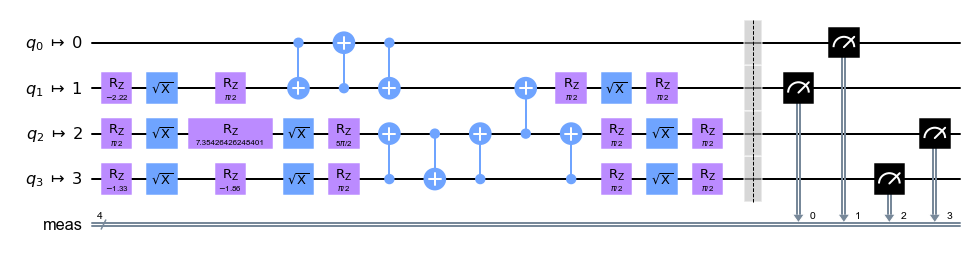

In [352]:
k, l = 29, 2
circuit_batches[k][l].draw(**D)

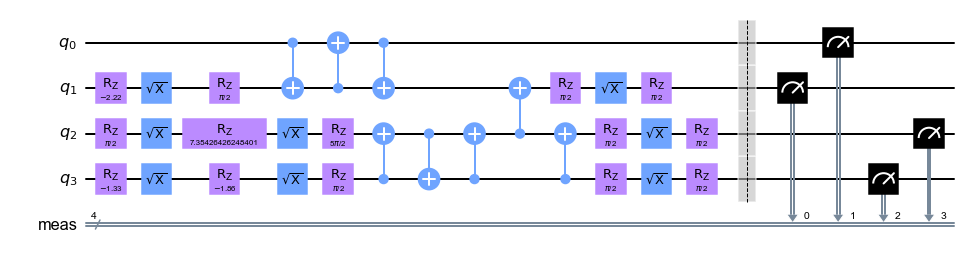

In [353]:
qc = remove_idle_qubits(circuit_batches[k][l])
qc.draw(**D)

In [11]:
ideal_exp_vals_estimator = []
for circuits in tqdm(circuit_batches):
    for trans_circuit in circuits:
        trans_circuit = remove_idle_qubits(trans_circuit, [0, 1, 2, 3])
        padded_obs = [SparsePauliOp(
            form_all_qubit_observable(obs, get_measurement_qubits(trans_circuit, 4), 4)
        ) for obs in obs_list]
        trans_circuit.remove_final_measurements()
        ideal_exp_vals_estimator.append(estimator_ideal.run([trans_circuit]*4, padded_obs).result().values.tolist())

  0%|          | 0/60 [00:00<?, ?it/s]

In [143]:
to_save = {
    'ideal': ideal_exp_vals_estimator,
    'noisy': noisy_exp_vals,
    'zne_mitigated': zne_mitigated_vals,
}
with open('./data/ising_init_from_qasm_hardware/shuffled/results.pk', 'wb') as file:
    pickle.dump(to_save, file)

In [ ]:
# import os
# from tqdm.notebook import tqdm
#
# def load_circuits(data_dir, filename=None, f_ext='.pk'):
#     circuits = []
#     ideal_exp_vals = []
#     if filename is None:
#         data_files = sorted([os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith(f_ext)])
#     else:
#         data_files = sorted([os.path.join(data_dir, f) for f in [filename]])
#     # print(data_files)
#     for data_file in tqdm(data_files):
#         for entry in pickle.load(open(data_file, 'rb')):
#             # circuits.append(entry['circuit'])
#             ideal_exp_vals.append(entry['ideal_exp_val'])
#     return ideal_exp_vals
#
# root1 = './data/ising_init_from_qasm_hardware/train'
# root2 = './data/ising_init_from_qasm_hardware/val'
# ideal_exp_vals = load_circuits(root1)
# ideal_exp_vals.extend(load_circuits(root2))

In [196]:
# ideal_exp_vals = [x.tolist() for x in ideal_exp_vals]

In [ ]:
# for ideal_1, ideal_2 in zip(ideal_exp_vals, ideal_exp_vals_estimator):
#     print([round(x, 4) for x in ideal_2])
#     print(ideal_1)
#     print('-'*5)

# Unshuffle

In [6]:
with open('./data/ising_init_from_qasm_hardware/shuffled/results.pk', 'rb') as file:
    loaded = pickle.load(file)
noisy_exp_vals = loaded['noisy']
zne_mitigated_vals = loaded['zne_mitigated']
ideal_exp_vals_estimator = loaded['ideal']

In [7]:
noisy_exp_vals = np.array(noisy_exp_vals)
zne_mitigated_vals = np.array(zne_mitigated_vals)

In [8]:
noisy_exp_vals = noisy_exp_vals.reshape(-1, 4).tolist()
zne_mitigated_vals = zne_mitigated_vals.reshape(-1, 4).tolist()

In [9]:
with open('./data/ising_init_from_qasm_hardware/shuffled/index_order.json', 'r') as file:
    index_order = json.load(file)

In [10]:
def unshuffle_list(shuffled_list, index_order):
    unshuffled_list = [None] * len(shuffled_list)
    for i, index in enumerate(index_order):
        unshuffled_list[index] = shuffled_list[i]
    return unshuffled_list

In [11]:
noisy_exp_vals = unshuffle_list(noisy_exp_vals, index_order)
zne_mitigated_vals = unshuffle_list(zne_mitigated_vals, index_order)
ideal_exp_vals_estimator = unshuffle_list(ideal_exp_vals_estimator, index_order)

In [12]:
list(zip(ideal_exp_vals_estimator, noisy_exp_vals, zne_mitigated_vals))

[([2.7755575615628914e-17,
   5.551115123125783e-17,
   -2.7755575615628914e-17,
   -8.326672684688674e-17],
  [0.072, -0.0206, 0.0904, 0.0052],
  [0.047599999999999976,
   -0.06840000000000002,
   0.08039999999999999,
   0.023200000000000005]),
 ([0.2822944097650154,
   1.0000000000000004,
   -0.4791774896080656,
   -0.13526912660159063],
  [0.2362, 0.9788, -0.3122, -0.1264],
  [0.2403999999999999, 0.9955999999999996, -0.33889999999999987, -0.1405]),
 ([2.7755575615628914e-17,
   5.551115123125783e-17,
   -2.7755575615628914e-17,
   -8.326672684688674e-17],
  [0.2762, -0.0022, 0.089, -0.0178],
  [0.26849999999999996,
   -0.046800000000000015,
   0.08739999999999999,
   -0.0005999999999999686]),
 ([0.2822944097650154,
   1.0000000000000004,
   -0.4791774896080656,
   -0.13526912660159063],
  [0.231, 0.9826, -0.2886, -0.1048],
  [0.23120000000000002,
   1.0025999999999997,
   -0.31960000000000005,
   -0.11900000000000001]),
 ([5.551115123125783e-17,
   0.0,
   -2.7755575615628914e-17,
 

In [328]:
# to_save = {
#     'ideal': ideal_exp_vals_estimator,
#     'noisy': noisy_exp_vals,
#     'zne_mitigated': zne_mitigated_vals,
# }
# with open('./data/ising_init_from_qasm_hardware/shuffled/results_unshuffled.pk', 'wb') as file:
#     pickle.dump(to_save, file)

# Train-test split

In [13]:
from tqdm.notebook import tqdm
all_circuits = []
for circuits in tqdm(circuit_batches):
    for trans_circuit in circuits:
        # trans_circuit = remove_idle_qubits(trans_circuit)
        all_circuits.append(trans_circuit)

  0%|          | 0/60 [00:00<?, ?it/s]

In [14]:
all_circuits_unshuffled = unshuffle_list(all_circuits, index_order)

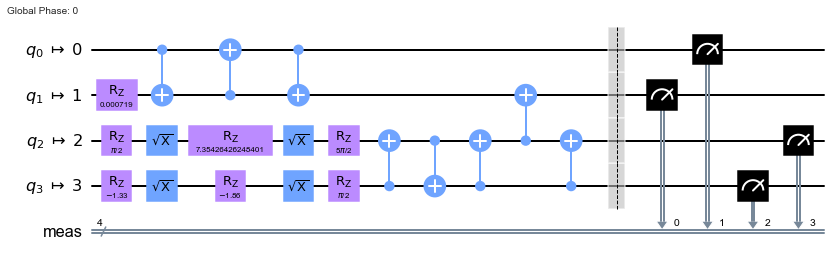

In [15]:
all_circuits_unshuffled[199].draw(**D)

In [16]:
# train_circuits, test_circuits = all_circuits_unshuffled[:2000], all_circuits_unshuffled[2000:]

In [24]:
all_ideal, all_noisy, all_zne, all_circuits, all_steps = [], [], [], [], []
train_ideal, train_noisy, train_zne, train_circuits, train_steps = [], [], [], [], []
test_ideal, test_noisy, test_zne, test_circuits, test_steps = [], [], [], [], []
for step, i in enumerate(range(0, 2000, 200)):
    all_ideal.extend(ideal_exp_vals_estimator[i:i+200])
    all_noisy.extend(noisy_exp_vals[i:i+200])
    all_zne.extend(zne_mitigated_vals[i:i+200])
    all_circuits.extend(all_circuits_unshuffled[i:i+200])
    all_steps.extend([step]*200)

for step, i in enumerate(range(2000, 3000, 100)):
    all_ideal.extend(ideal_exp_vals_estimator[i:i+100])
    all_noisy.extend(noisy_exp_vals[i:i+100])
    all_zne.extend(zne_mitigated_vals[i:i+100])
    all_circuits.extend(all_circuits_unshuffled[i:i+100])
    all_steps.extend([step]*100)

rows = []
for ideal, noisy, zne, circ, s in zip(all_ideal, all_noisy, all_zne, all_circuits, all_steps):
    rows.append([ideal, noisy, zne, circ, s])

rows = sorted(rows, key=lambda x: (x[-1]))

In [26]:
df = pd.DataFrame(rows)
df.columns = ['ideal', 'noisy', 'zne', 'circ', 'step']
df

,ideal,noisy,zne,circ,step
0,"[2.7755575615628914e-17, 5.551115123125783e-17...","[0.072, -0.0206, 0.0904, 0.0052]","[0.047599999999999976, -0.06840000000000002, 0...","((Instruction(name='rz', num_qubits=1, num_clb...",0
1,"[0.2822944097650154, 1.0000000000000004, -0.47...","[0.2362, 0.9788, -0.3122, -0.1264]","[0.2403999999999999, 0.9955999999999996, -0.33...","((Instruction(name='rz', num_qubits=1, num_clb...",0
2,"[2.7755575615628914e-17, 5.551115123125783e-17...","[0.2762, -0.0022, 0.089, -0.0178]","[0.26849999999999996, -0.046800000000000015, 0...","((Instruction(name='rz', num_qubits=1, num_clb...",0
3,"[0.2822944097650154, 1.0000000000000004, -0.47...","[0.231, 0.9826, -0.2886, -0.1048]","[0.23120000000000002, 1.0025999999999997, -0.3...","((Instruction(name='rz', num_qubits=1, num_clb...",0
4,"[5.551115123125783e-17, 0.0, -2.77555756156289...","[-0.0104, -0.0252, 0.1144, -0.0408]","[-0.011399999999999995, -0.08460000000000004, ...","((Instruction(name='rz', num_qubits=1, num_clb...",0
...,...,...,...,...,...
2995,"[-0.08828510312411605, -0.33965348162590575, 0...","[-0.001, -0.1324, 0.13, 0.1472]","[-0.042300000000000025, -0.1814, 0.19019999999...","((Instruction(name='rz', num_qubits=1, num_clb...",9
2996,"[0.026355128084189855, -0.0033706674882890697,...","[0.1384, 0.125, 0.0562, 0.0674]","[0.14669999999999994, 0.15119999999999997, 0.0...","((Instruction(name='rz', num_qubits=1, num_clb...",9
2997,"[0.03128533930903135, -0.06153497460552665, -0...","[0.0986, -0.0774, 0.0484, 0.1782]","[0.09299999999999999, -0.1106, 0.0626999999999...","((Instruction(name='rz', num_qubits=1, num_clb...",9
2998,"[0.05365543668507869, -0.052795221433028616, -...","[0.1726, 0.0268, 0.087, 0.2026]","[0.18169999999999992, -0.007100000000000058, 0...","((Instruction(name='rz', num_qubits=1, num_clb...",9


In [27]:
train_size_per_step, test_size_per_step = 50, 250
train_rows = df.groupby('step').head(train_size_per_step).reset_index(drop=True)
test_rows = df.groupby('step').tail(test_size_per_step).reset_index(drop=True)

train_ideal, train_noisy, train_zne, train_circuits, train_steps = list(train_rows['ideal']), list(train_rows['noisy']), list(train_rows['zne']), list(train_rows['circ']), list(train_rows['step'])
test_ideal, test_noisy, test_zne, test_circuits, test_steps = list(test_rows['ideal']), list(test_rows['noisy']), list(test_rows['zne']), list(test_rows['circ']), list(test_rows['step'])

# Inspect Train and Test

In [28]:
to_df_train = []
for ideal, noisy, zne, s in zip(train_ideal, train_noisy, train_zne, train_steps):
    row = dict()
    row['ideal'] = ideal
    row['noisy'] = noisy
    row['zne'] = zne
    row['step'] = s
    to_df_train.append(row)

to_df_test = []
for ideal, noisy, zne, s in zip(test_ideal, test_noisy, test_zne, test_steps):
    row = dict()
    row['ideal'] = ideal
    row['noisy'] = noisy
    row['zne'] = zne
    row['step'] = s
    to_df_test.append(row)

df_train = pd.DataFrame(to_df_train)
df_train

,ideal,noisy,zne,step
0,"[2.7755575615628914e-17, 5.551115123125783e-17...","[0.072, -0.0206, 0.0904, 0.0052]","[0.047599999999999976, -0.06840000000000002, 0...",0
1,"[0.2822944097650154, 1.0000000000000004, -0.47...","[0.2362, 0.9788, -0.3122, -0.1264]","[0.2403999999999999, 0.9955999999999996, -0.33...",0
2,"[2.7755575615628914e-17, 5.551115123125783e-17...","[0.2762, -0.0022, 0.089, -0.0178]","[0.26849999999999996, -0.046800000000000015, 0...",0
3,"[0.2822944097650154, 1.0000000000000004, -0.47...","[0.231, 0.9826, -0.2886, -0.1048]","[0.23120000000000002, 1.0025999999999997, -0.3...",0
4,"[5.551115123125783e-17, 0.0, -2.77555756156289...","[-0.0104, -0.0252, 0.1144, -0.0408]","[-0.011399999999999995, -0.08460000000000004, ...",0
...,...,...,...,...
495,"[-0.1195223205337127, -0.422936662137479, -0.0...","[-0.1414, -0.334, -0.0956, -0.105]","[-0.15399999999999994, -0.46950000000000003, -...",9
496,"[0.03468435284046983, 0.5033074694656495, -0.2...","[-0.0138, 0.2812, -0.098, 0.0674]","[0.03960000000000001, 0.3844999999999999, -0.1...",9
497,"[-0.038374547811965115, -0.015929757330378075,...","[0.0086, -0.1234, -0.0582, -0.1892]","[-0.02970000000000004, -0.15299999999999994, -...",9
498,"[-0.042503203687466296, -0.04886391037068477, ...","[0.0142, -0.1112, -0.0958, -0.1924]","[-0.0028000000000000178, -0.1591, -0.126199999...",9


In [29]:
df = pd.DataFrame(to_df_test)

def l2_dist(list1, list2):
    return np.sqrt(np.sum([(a - b)**2 for a, b in zip(list1, list2)]))

for col in df.columns:
    if col not in ['step', 'ideal']:
        df[f'L2_{col}'] = df.apply(lambda row: l2_dist(row['ideal'], row[col]), axis=1)

df_mean = df.groupby('step').agg('mean')
df_ste = df.groupby('step').agg('std') / np.sqrt(len(df[df['step']==0]))

/var/folders/kj/mfqyg_tj77nf4gt67lvscdkw0000gn/T/ipykernel_65830/3049952033.py:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_mean = df.groupby('step').agg('mean')
/var/folders/kj/mfqyg_tj77nf4gt67lvscdkw0000gn/T/ipykernel_65830/3049952033.py:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_ste = df.groupby('step').agg('std') / np.sqrt(len(df[df['step']==0]))


In [30]:
df_mean

,L2_noisy,L2_zne
step,,
0,0.143743,0.143702
1,0.175321,0.169557
2,0.222085,0.183910
3,0.219112,0.177614
4,0.225672,0.184633
5,0.193042,0.169360
6,0.217714,0.183535
7,0.232615,0.204955
8,0.230549,0.222320


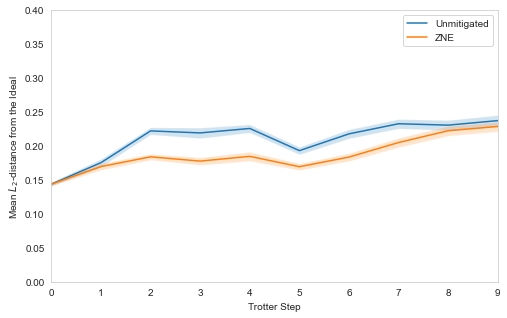

In [31]:
plt.style.use({'figure.facecolor':'white'})
plt.figure(figsize=(8, 5))
xs = sorted(set(df.step))
legend_labels = ['Unmitigated', 'ZNE']
for i, col in enumerate(['L2_noisy', 'L2_zne']):
# legend_labels = ['Unmitigated', 'RF Mitigated']
# for i, col in enumerate(['L2_noisy', 'L2_rfr_list']):
    plt.plot(xs, df_mean[col], label=legend_labels[i])
    plt.fill_between(x=xs, y1=df_mean[col]-df_ste[col], y2=df_mean[col]+df_ste[col], alpha=0.2)
plt.xlabel('Trotter Step')
plt.ylabel(r'Mean $L_2$-distance from the Ideal')
plt.ylim([0, 0.4])
plt.xlim([0, 9])
ymin, ymax = plt.gca().get_ylim()
plt.ylim(ymin, ymax)
plt.legend()
plt.grid(None)
plt.show()

# RF

In [32]:
import mlp
import importlib
importlib.reload(mlp)
from mlp import MLP1, MLP2, MLP3, encode_data, encode_data_v2_ecr
X_train, y_train = encode_data_v2_ecr(train_circuits, train_ideal, train_noisy, obs_size=4, two_q_gate='cx')
X_test, y_test = encode_data_v2_ecr(test_circuits, test_ideal, test_noisy, obs_size=4, two_q_gate='cx')

In [33]:
BATCH_SIZE = 32
train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataset = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE*1000, shuffle=False)

In [34]:
X_train = pd.DataFrame(X_train)
y_train = pd.DataFrame(y_train)
X_test = pd.DataFrame(X_test)
y_test = pd.DataFrame(y_test)

In [35]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
rfr_tree_list = []
for q in range(4):
    rfr = RandomForestRegressor(n_estimators=100)
    rfr.fit(X_train, y_train.iloc[:, q])
    rfr_tree_list.append(rfr)

In [36]:
# with open('./model/ising_init_from_qasm_hardware/rfr_list.pk', 'wb') as file:
#     pickle.dump(rfr_tree_list, file)

RMSE_noisy_0: 0.06371962731138575
RMSE_mitigated_0: 0.02992620879253221
RMSE_noisy_1: 0.14266696586500827
RMSE_mitigated_1: 0.10060497345139847
RMSE_noisy_2: 0.09719701642269073
RMSE_mitigated_2: 0.054086110062517394
RMSE_noisy_3: 0.1449852102185559
RMSE_mitigated_3: 0.09008654822804739
RMSE_noisy: 0.11713456496421219
RMSE_mitigated: 0.07425939692926055


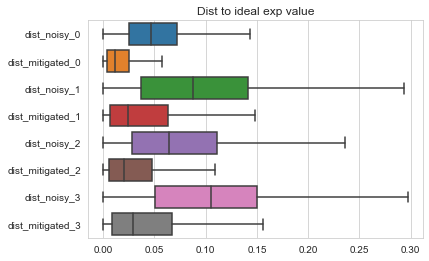

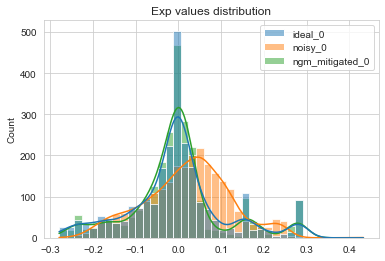

In [37]:
distances = []

num_spins = 4

for batch_X, batch_y in test_loader:
    out = []
    for q, model in enumerate(rfr_tree_list):
        out.append(model.predict(batch_X[:, :]))
    out = np.array(out).transpose()

    for ideal, noisy, ngm_mitigated in zip(
        batch_y.tolist(),
        batch_X[:, -num_spins:].tolist(),
        out.tolist()
    ):
        for q in range(num_spins):
            ideal_q = ideal[q]
            noisy_q = noisy[q]
            ngm_mitigated_q = ngm_mitigated[q]
            distances.append({
                f"ideal_{q}": ideal_q,
                f"noisy_{q}": noisy_q,
                f"ngm_mitigated_{q}": ngm_mitigated_q,
                f"dist_noisy_{q}": np.abs(ideal_q - noisy_q),
                f"dist_mitigated_{q}": np.abs(ideal_q - ngm_mitigated_q),
                f"dist_sq_noisy_{q}": np.square(ideal_q - noisy_q),
                f"dist_sq_mitigated_{q}": np.square(ideal_q - ngm_mitigated_q),
            })

plt.style.use({'figure.facecolor':'white'})

df = pd.DataFrame(distances)

for q in range(num_spins):
    print(f'RMSE_noisy_{q}:', np.sqrt(df[f"dist_sq_noisy_{q}"].mean()))
    print(f'RMSE_mitigated_{q}:', np.sqrt(df[f"dist_sq_mitigated_{q}"].mean()))

print(f'RMSE_noisy:', np.sqrt(np.mean([df[f"dist_sq_noisy_{q}"].mean() for q in range(num_spins)])))
print(f'RMSE_mitigated:', np.sqrt(np.mean([df[f"dist_sq_mitigated_{q}"].mean() for q in range(num_spins)])))

sns.boxplot(data=df[["dist_noisy_0", "dist_mitigated_0", "dist_noisy_1", "dist_mitigated_1", "dist_noisy_2", "dist_mitigated_2", "dist_noisy_3", "dist_mitigated_3"]], orient="h", showfliers = False)
plt.title("Dist to ideal exp value")
plt.show()

sns.histplot([df['ideal_0'], df['noisy_0'], df["ngm_mitigated_0"]], kde=True, bins=40)
plt.title("Exp values distribution")
plt.show()

In [38]:
to_df = []

start = 0 #300*9
end = 100000000 #300*10

models = [(rfr_tree_list, 'rfr_list')]
models.append((None, 'zne'))

for circ, ideal, noisy, zne, s in tqdm(zip(test_circuits, test_ideal, test_noisy, test_zne, test_steps), total=len(test_circuits)):
    row = dict()
    row['ideal'] = ideal
    row['noisy'] = noisy
    row['step'] = s

    X, _ = encode_data_v2_ecr([circ], ideal, [noisy], obs_size=4, two_q_gate='cx')

    for j, (model, name) in enumerate(models):
        if name in ['rfr_list']:
            row[name] = []
            for q, m in enumerate(model):
                row[name].append(m.predict(X))
            row[name] = np.array(row[name]).transpose()[0]
        elif name in ['zne']:
            row[name] = zne
        else:
            raise NotImplementedError

    to_df.append(row)

df = pd.DataFrame(to_df)

  0%|          | 0/2500 [00:00<?, ?it/s]

In [39]:
df = pd.DataFrame(to_df)

def l2_dist(list1, list2):
    return np.sqrt(np.sum([(a - b)**2 for a, b in zip(list1, list2)]))

for col in df.columns:
    if col not in ['step', 'ideal']:
        df[f'L2_{col}'] = df.apply(lambda row: l2_dist(row['ideal'], row[col]), axis=1)

df_mean = df.groupby('step').agg('mean')
df_ste = df.groupby('step').agg('std') / np.sqrt(len(df[df['step']==0]))

/var/folders/kj/mfqyg_tj77nf4gt67lvscdkw0000gn/T/ipykernel_65830/1969995707.py:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_mean = df.groupby('step').agg('mean')
/var/folders/kj/mfqyg_tj77nf4gt67lvscdkw0000gn/T/ipykernel_65830/1969995707.py:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_ste = df.groupby('step').agg('std') / np.sqrt(len(df[df['step']==0]))


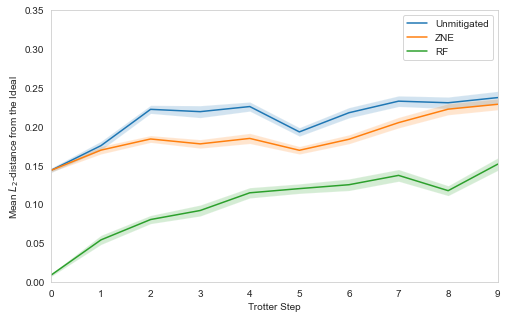

In [40]:
plt.style.use({'figure.facecolor':'white'})
plt.figure(figsize=(8, 5))
xs = sorted(set(df.step))
legend_labels = ['Unmitigated', 'ZNE', 'RF']
for i, col in enumerate(['L2_noisy', 'L2_zne', 'L2_rfr_list']):
# legend_labels = ['Unmitigated', 'RF Mitigated']
# for i, col in enumerate(['L2_noisy', 'L2_rfr_list']):
    plt.plot(xs, df_mean[col], label=legend_labels[i])
    plt.fill_between(x=xs, y1=df_mean[col]-df_ste[col], y2=df_mean[col]+df_ste[col], alpha=0.2)
plt.xlabel('Trotter Step')
plt.ylabel(r'Mean $L_2$-distance from the Ideal')
plt.ylim([0, 0.35])
plt.xlim([0, 9])
ymin, ymax = plt.gca().get_ylim()
plt.ylim(ymin, ymax)
plt.legend()
plt.grid(None)
plt.show()

In [41]:
# to_save = {
#     'df_mean': df_mean,
#     'df_ste': df_ste,
#     'df': df
# }
# with open('/Users/haoranliao/GitHub/blackwater/docs/paper_figures/hardware_over_depth.pk', 'wb') as file:
#     pickle.dump(to_save, file)

------------------------------
train size per step: 5


  0%|          | 0/2950 [00:00<?, ?it/s]

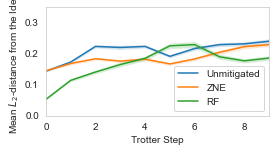

------------------------------
train size per step: 10


  0%|          | 0/2900 [00:00<?, ?it/s]

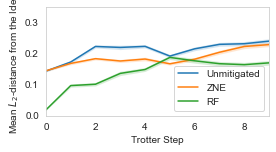

------------------------------
train size per step: 15


  0%|          | 0/2850 [00:00<?, ?it/s]

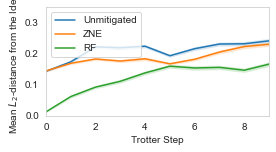

------------------------------
train size per step: 20


  0%|          | 0/2800 [00:00<?, ?it/s]

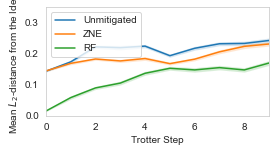

------------------------------
train size per step: 30


  0%|          | 0/2700 [00:00<?, ?it/s]

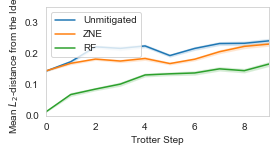

------------------------------
train size per step: 40


  0%|          | 0/2600 [00:00<?, ?it/s]

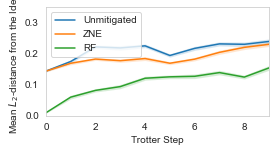

------------------------------
train size per step: 50


  0%|          | 0/2500 [00:00<?, ?it/s]

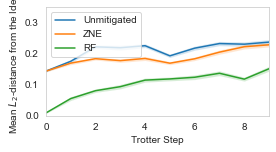

------------------------------
train size per step: 60


  0%|          | 0/2400 [00:00<?, ?it/s]

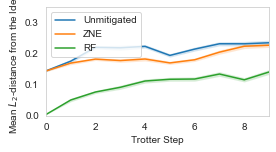

------------------------------
train size per step: 70


  0%|          | 0/2300 [00:00<?, ?it/s]

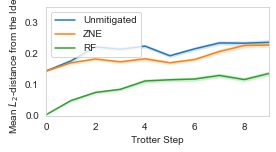

------------------------------
train size per step: 80


  0%|          | 0/2200 [00:00<?, ?it/s]

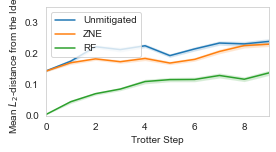

------------------------------
train size per step: 100


  0%|          | 0/2000 [00:00<?, ?it/s]

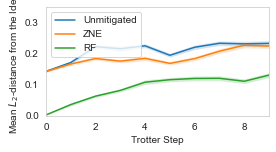

------------------------------
train size per step: 150


  0%|          | 0/1500 [00:00<?, ?it/s]

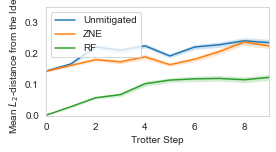

------------------------------
train size per step: 200


  0%|          | 0/1000 [00:00<?, ?it/s]

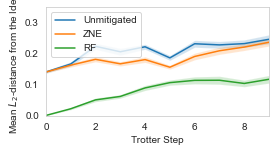

In [91]:
import warnings
warnings.filterwarnings('ignore')

all_ideal, all_noisy, all_zne, all_circuits, all_steps = [], [], [], [], []
train_ideal, train_noisy, train_zne, train_circuits, train_steps = [], [], [], [], []
test_ideal, test_noisy, test_zne, test_circuits, test_steps = [], [], [], [], []
for step, i in enumerate(range(0, 2000, 200)):
    all_ideal.extend(ideal_exp_vals_estimator[i:i+200])
    all_noisy.extend(noisy_exp_vals[i:i+200])
    all_zne.extend(zne_mitigated_vals[i:i+200])
    all_circuits.extend(all_circuits_unshuffled[i:i+200])
    all_steps.extend([step]*200)

for step, i in enumerate(range(2000, 3000, 100)):
    all_ideal.extend(ideal_exp_vals_estimator[i:i+100])
    all_noisy.extend(noisy_exp_vals[i:i+100])
    all_zne.extend(zne_mitigated_vals[i:i+100])
    all_circuits.extend(all_circuits_unshuffled[i:i+100])
    all_steps.extend([step]*100)

rows = []
for ideal, noisy, zne, circ, s in zip(all_ideal, all_noisy, all_zne, all_circuits, all_steps):
    rows.append([ideal, noisy, zne, circ, s])

rows = sorted(rows, key=lambda x: (x[-1]))

df = pd.DataFrame(rows)
df.columns = ['ideal', 'noisy', 'zne', 'circ', 'step']

for train_size_per_step in [5, 10, 15, 20, 30, 40, 50, 60, 70, 80, 100, 150, 200]:
    print('-'*30)
    print('train size per step:', train_size_per_step)
    test_size_per_step = 300 - train_size_per_step
    train_rows = df.groupby('step').head(train_size_per_step).reset_index(drop=True)
    test_rows = df.groupby('step').tail(test_size_per_step).reset_index(drop=True)

    train_ideal, train_noisy, train_zne, train_circuits, train_steps = list(train_rows['ideal']), list(train_rows['noisy']), list(train_rows['zne']), list(train_rows['circ']), list(train_rows['step'])
    test_ideal, test_noisy, test_zne, test_circuits, test_steps = list(test_rows['ideal']), list(test_rows['noisy']), list(test_rows['zne']), list(test_rows['circ']), list(test_rows['step'])

    X_train, y_train = encode_data_v2_ecr(train_circuits, train_ideal, train_noisy, obs_size=4, two_q_gate='cx')
    X_test, y_test = encode_data_v2_ecr(test_circuits, test_ideal, test_noisy, obs_size=4, two_q_gate='cx')

    BATCH_SIZE = 32
    train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_dataset = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE*1000, shuffle=False)

    X_train = pd.DataFrame(X_train)
    y_train = pd.DataFrame(y_train)
    X_test = pd.DataFrame(X_test)
    y_test = pd.DataFrame(y_test)


    rfr_tree_list = []
    for q in range(4):
        rfr = RandomForestRegressor(n_estimators=100)
        rfr.fit(X_train, y_train.iloc[:, q])
        rfr_tree_list.append(rfr)

    to_df = []

    start = 0 #300*9
    end = 100000000 #300*10

    models = [(rfr_tree_list, 'rfr_list')]
    models.append((None, 'zne'))

    for circ, ideal, noisy, zne, s in tqdm(zip(test_circuits, test_ideal, test_noisy, test_zne, test_steps), total=len(test_circuits)):
        row = dict()
        row['ideal'] = ideal
        row['noisy'] = noisy
        row['step'] = s

        X, _ = encode_data_v2_ecr([circ], ideal, [noisy], obs_size=4, two_q_gate='cx')

        for j, (model, name) in enumerate(models):
            if name in ['rfr_list']:
                row[name] = []
                for q, m in enumerate(model):
                    row[name].append(m.predict(X))
                row[name] = np.array(row[name]).transpose()[0]
            elif name in ['zne']:
                row[name] = zne
            else:
                raise NotImplementedError

        to_df.append(row)

    df_rf = pd.DataFrame(to_df)

    def l2_dist(list1, list2):
        return np.sqrt(np.sum([(a - b)**2 for a, b in zip(list1, list2)]))

    for col in df_rf.columns:
        if col not in ['step', 'ideal']:
            df_rf[f'L2_{col}'] = df_rf.apply(lambda row: l2_dist(row['ideal'], row[col]), axis=1)

    df_mean = df_rf.groupby('step').agg('mean')
    df_ste = df_rf.groupby('step').agg('std') / np.sqrt(len(df_rf[df_rf['step']==0]))

    plt.style.use({'figure.facecolor':'white'})
    plt.figure(figsize=(4, 2))
    xs = sorted(set(df_rf.step))
    legend_labels = ['Unmitigated', 'ZNE', 'RF']
    for i, col in enumerate(['L2_noisy', 'L2_zne', 'L2_rfr_list']):
    # legend_labels = ['Unmitigated', 'RF Mitigated']
    # for i, col in enumerate(['L2_noisy', 'L2_rfr_list']):
        plt.plot(xs, df_mean[col], label=legend_labels[i])
        plt.fill_between(x=xs, y1=df_mean[col]-df_ste[col], y2=df_mean[col]+df_ste[col], alpha=0.2)
    plt.xlabel('Trotter Step')
    plt.ylabel(r'Mean $L_2$-distance from the Ideal')
    plt.ylim([0, 0.35])
    plt.xlim([0, 9])
    ymin, ymax = plt.gca().get_ylim()
    plt.ylim(ymin, ymax)
    plt.legend()
    plt.grid(None)
    plt.show()